# Projecto -> Ferramenta de Previsão de preço de imóvel 

Base de dados: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

## Importar as bibliotecas e base de dados

In [97]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

#não apresentar os warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# crio um dicionário com as 3 primeiras letras e atribuo o n.º do mês

meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}


# pasta aonde tenho os csv mensais com a informação 
pasta_arquivos_csv= Path(r'dataset')

#crio um dataframe vazio aonde vou colocar a informação
base_airbnb=pd.DataFrame()

#vou percorrer todos os arquivos e faço o append ao meu dataset criado
for arquivo in pasta_arquivos_csv.iterdir():
    
    nome_mes=arquivo.name[:3] # fico com as 3 primeiras letras do nome do arquivo
    mes=meses[nome_mes] #identifico o n.º do mês utilizando o dicionário
    
    ano=arquivo.name[-8:] #retiro o ano -> últimos 8 caracteres
    ano=int(ano.replace('.csv','')) #substituo por vazio 
    df=pd.read_csv(pasta_arquivos_csv/arquivo.name,low_memory=False)
    df['ano']=ano #crio a coluna ano -> está no nome nos ficheiros
    df['mes']=mes # crio a coluna do ano
    base_airbnb=base_airbnb.append(df) # faço o append
    
#display(base_airbnb)

In [3]:
  df['ano']

0        2019
1        2019
2        2019
3        2019
4        2019
         ... 
34324    2019
34325    2019
34326    2019
34327    2019
34328    2019
Name: ano, Length: 34329, dtype: int64

## Limpar a base de dados

In [4]:
# ver as colunas -> tenho 108 colunas
print(list(base_airbnb.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

In [5]:
base_airbnb.head(1000).to_csv('primeiros_registos.csv',sep=';')

In [6]:
#coluna vazia
print(base_airbnb[['experiences_offered']].value_counts())

experiences_offered
none                   902210
dtype: int64


In [7]:
#comparar 2 variáveis
print((base_airbnb['host_total_listings_count']==base_airbnb['host_listings_count']).value_counts())

True     901750
False       460
dtype: int64


In [8]:
print(base_airbnb['square_feet'].isnull().sum())

888162


In [9]:
# Colunas selecionadas -> escolhi 34 variáveis
colunas=['host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

In [10]:
base_airbnb=base_airbnb.loc[:,colunas]
display(base_airbnb)

host_response_rate host_is_superhost  host_listings_count   latitude  \
0                    NaN                 f                  1.0 -22.946854   
1                   100%                 t                  2.0 -22.965919   
2                   100%                 f                  1.0 -22.985698   
3                   100%                 f                  3.0 -22.977117   
4                   100%                 t                  1.0 -22.983024   
...                  ...               ...                  ...        ...   
34324                93%                 f                  0.0 -23.003180   
34325                NaN                 f                  0.0 -22.966640   
34326                74%                 f                 32.0 -22.962080   
34327                NaN                 f                  0.0 -23.003400   
34328                38%                 f                  5.0 -23.010560   

       longitude property_type        room_type  accommodates  bathrooms  \
0     -43.182737     Apartment  Entire home/apt             4        1.0   
1     -43.178962   Condominium  Entire home/apt             5        1.0   
2     -43.201935     Apartment  Entire home/apt             2        1.0   
3     -43.190454     Apartment  Entire home/apt             3        1.0   
4     -43.214270     Apartment  Entire home/apt             3        1.0   
...          ...           ...              ...           ...        ...   
34324 -43.342840     Apartment  Entire home/apt             4        1.0   
34325 -43.393450     Apartment  Entire home/apt             4        2.0   
34326 -43.175520     Apartment  Entire home/apt             5        1.0   
34327 -43.341820     Apartment  Entire home/apt             4        1.0   
34328 -43.363350     Apartment     Private room             2        0.0   

       bedrooms  ...  review_scores_cleanliness review_scores_checkin  \
0           0.0  ...                        9.0                   9.0   
1           2.0  ...                        9.0                  10.0   
2           1.0  ...                       10.0                  10.0   
3           1.0  ...                       10.0                  10.0   
4           1.0  ...                       10.0                  10.0   
...         ...  ...                        ...                   ...   
34324       0.0  ...                        NaN                   NaN   
34325       2.0  ...                        NaN                   NaN   
34326       1.0  ...                        NaN                   NaN   
34327       1.0  ...                        NaN                   NaN   
34328       1.0  ...                        NaN                   NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable  is_business_travel_ready          cancellation_policy  \
0                    f                         f  strict_14_with_grace_period   
1                    t                         f                       strict   
2                    f                         f                       stri

## Tratar valores vazios -> NAN

In [11]:
print(base_airbnb.isnull().sum())

host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_scores_communication    448415
review_score

In [12]:
# eliminar as colunas que tem NAN superiores a 300 mil
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 30000:
        base_airbnb=base_airbnb.drop(coluna,axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [13]:
print(base_airbnb.shape)

(902210, 23)


In [14]:
# excluir as linhas com NAN -> existe um método próprio para isso
base_airbnb=base_airbnb.dropna()
print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


## Verificar o tipo de dados

In [15]:
print(base_airbnb.dtypes)
print('-'* 60)
print(base_airbnb.iloc[0]) #printar a primeira linha

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

In [16]:
#price e extra_people são object e não float-> $ e virgula como separador dos milhares
base_airbnb['price']=base_airbnb['price'].str.replace('$','')
base_airbnb['price']=base_airbnb['price'].str.replace(',','')
base_airbnb['price']=base_airbnb['price'].astype(np.float32, copy=False)

base_airbnb['extra_people']=base_airbnb['extra_people'].str.replace('$','')
base_airbnb['extra_people']=base_airbnb['extra_people'].str.replace(',','')
base_airbnb['extra_people']=base_airbnb['extra_people'].astype(np.float32, copy=False)

In [17]:
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


## Análise Exploratória e Tratar Outliers

### Correlação

In [18]:
# análise da correlação
print((base_airbnb.corr()))

                     host_listings_count  latitude  longitude  accommodates  \
host_listings_count             1.000000 -0.034115   0.063635      0.069320   
latitude                       -0.034115  1.000000   0.370416     -0.142082   
longitude                       0.063635  0.370416   1.000000     -0.121746   
accommodates                    0.069320 -0.142082  -0.121746      1.000000   
bathrooms                       0.022332 -0.169135  -0.170504      0.521909   
bedrooms                        0.039712 -0.165050  -0.186332      0.675913   
beds                            0.042788 -0.113931  -0.110392      0.692740   
price                           0.092306 -0.092437  -0.085526      0.269929   
guests_included                 0.041932 -0.091123   0.049375      0.317563   
extra_people                   -0.031589 -0.041113   0.001723      0.078709   
minimum_nights                 -0.006441 -0.016090  -0.019213      0.024583   
maximum_nights                 -0.000100 -0.001386  

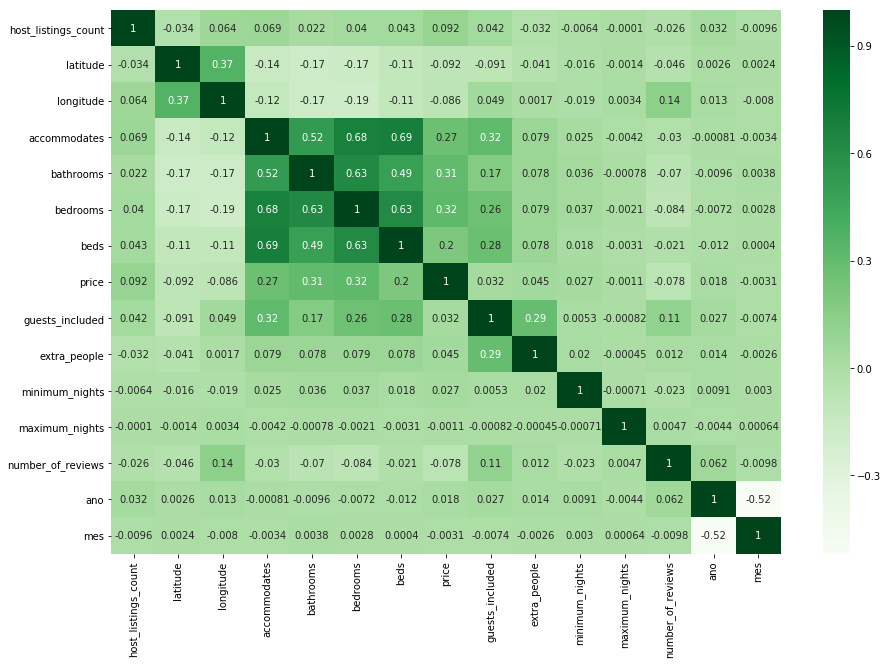

In [19]:
plt.figure(figsize=(15,10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')

### OUTLIERS

In [20]:
# função para identificar outliers [Q1-1.5* Amplitude; Q3 +1.5* Amplitude] -> Amplitude [Q3-Q1]

def limites(coluna):
    q1=coluna.quantile(0.25)
    q3=coluna.quantile(0.75)
    amplitude=q3-q1
    return q1-1.5*amplitude, q3+1.5*amplitude

# função para eliminar os outliers 

def excluir_outliers(df,nome_coluna):
    qtd_linhas=base_airbnb.shape[0]
    lim_inf,lim_sup=limites(df[nome_coluna])
    df=df.loc[(df[nome_coluna]>=lim_inf) & (df[nome_coluna]<=lim_sup) ,:]
    linhas_removidas=qtd_linhas - df.shape[0]
    return df, linhas_removidas

In [21]:
print(limites(base_airbnb['price']))

(-524.0, 1276.0)


In [22]:
# testar os resultados
print(base_airbnb['price'].describe())

count    897709.000000
mean        648.062195
std        1705.104980
min           0.000000
25%         151.000000
50%         297.000000
75%         601.000000
max      138288.000000
Name: price, dtype: float64


In [23]:
#Limite inferior
print(151-1.5*(601-151))

-524.0


In [24]:
#Limite superior
print(601+1.5*(601-151))

1276.0


In [25]:
#fuções para construir gráficos -> input é sempre uma coluna do dataframe

def diagrama_caixa(coluna):
    fig, (ax1,ax2)=plt.subplots(1,2)
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna,ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna,ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.distplot(coluna,hist=True)
    
def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax=sns.barplot(x=coluna.value_counts().index,y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

#### Variável contínua -> variável price

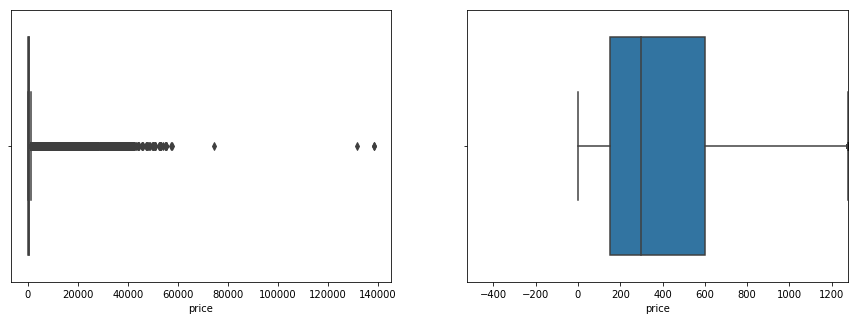

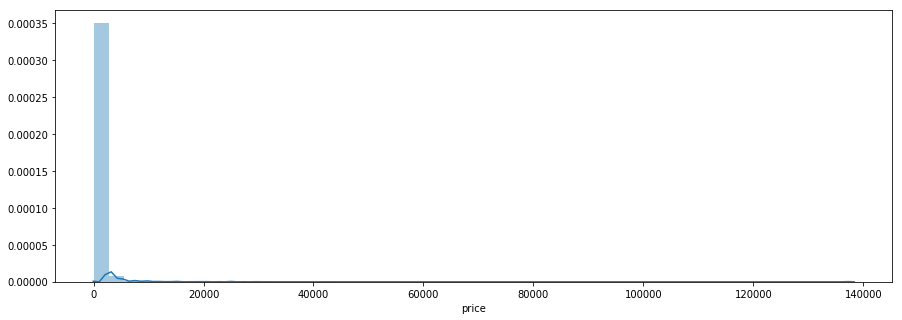

In [26]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [27]:
# opção: remover outliers
base_airbnb, qtd_linhas=excluir_outliers(base_airbnb, 'price')
print(f'{qtd_linhas} linhas removidas')

87282 linhas removidas


(810427, 23)


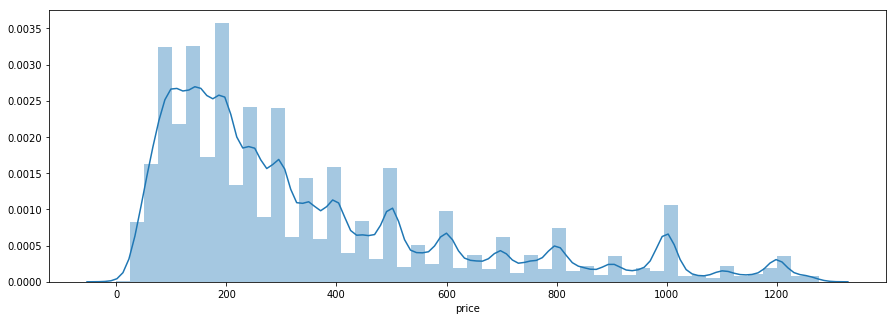

In [28]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

#### Variável contínua ->l extra_people

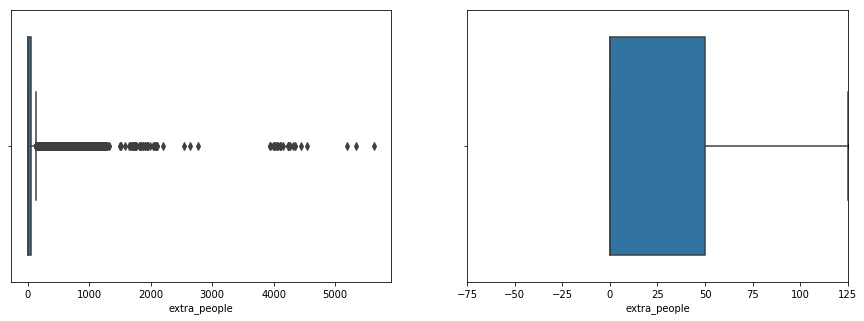

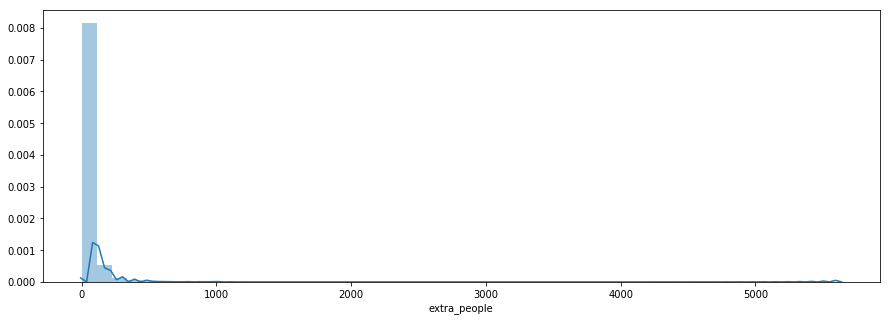

In [29]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [30]:
# opção: remover outliers
base_airbnb, qtd_linhas=excluir_outliers(base_airbnb, 'extra_people')
print(f'{qtd_linhas} linhas removidas')

59194 linhas removidas


(751233, 23)


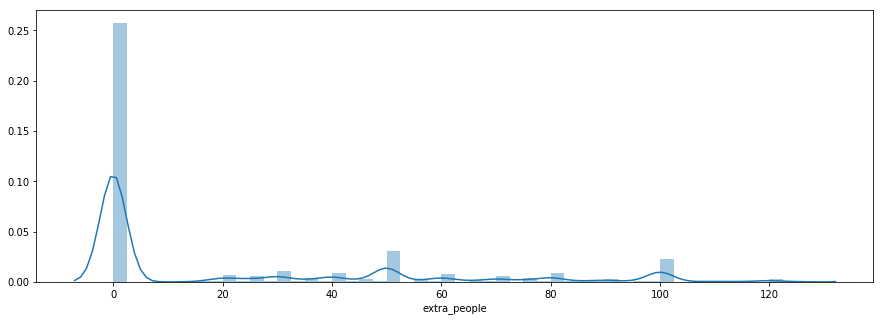

In [31]:
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

#### Variáveis discretas -> host_listings_count

1) host_listings_count
2) accommodates
3) bathrooms                   
4) bedrooms                     
5) beds                        
6) guests_included               
7) minimum_nights                
8) maximum_nights                 
9) number_of_reviews              

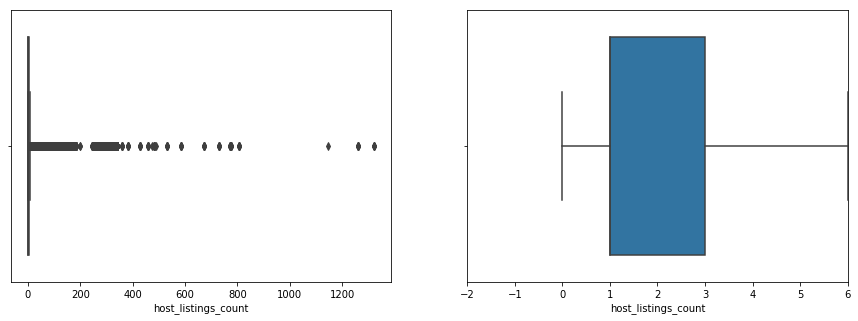

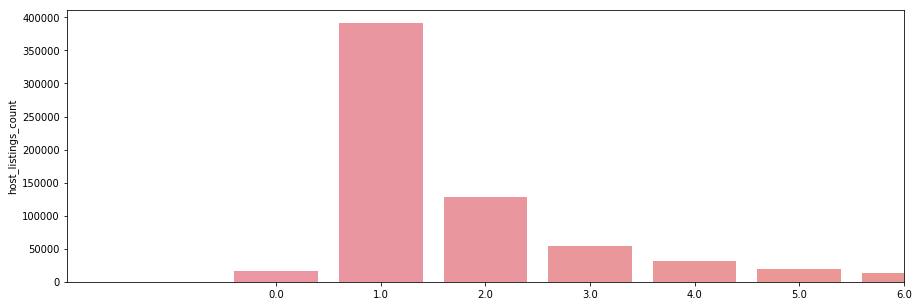

In [32]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliárias ou profissionais que gerenciam imóveis no airbnb).

In [33]:
# opção: remover outliers
base_airbnb, qtd_linhas=excluir_outliers(base_airbnb, 'host_listings_count')
print(f'{qtd_linhas} linhas removidas')

97723 linhas removidas


#### Variáveis discretas -> accommodates

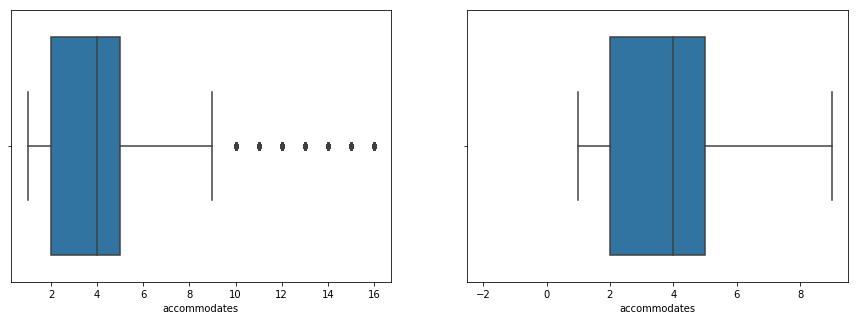

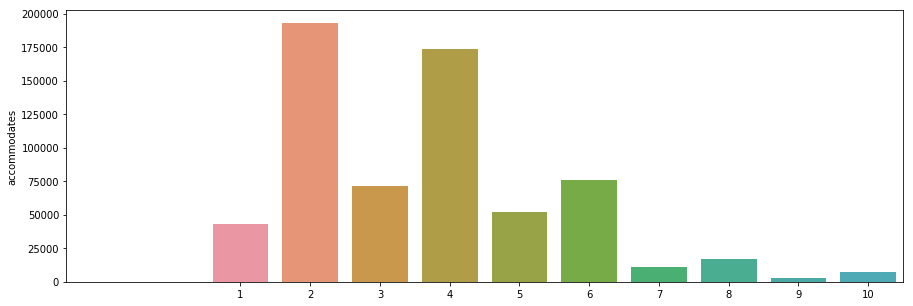

In [34]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [35]:
# opção: remover outliers
base_airbnb, qtd_linhas=excluir_outliers(base_airbnb, 'accommodates')
print(f'{qtd_linhas} linhas removidas')

13146 linhas removidas


#### Variáveis discretas -> bathrooms

(-0.5, 3.5)


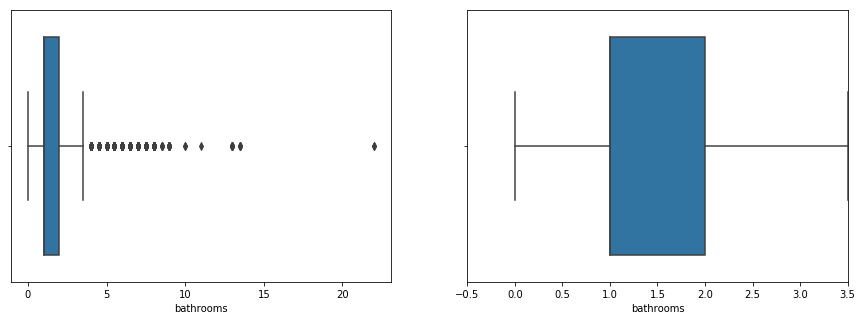

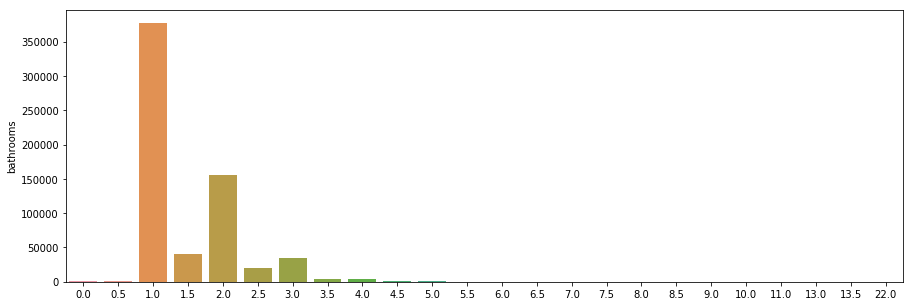

In [36]:
diagrama_caixa(base_airbnb['bathrooms'])
#grafico_barra(base_airbnb['bathrooms'])

#vou querer um gráfico com todos os valores
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index,y=base_airbnb['bathrooms'].value_counts())

print(limites(base_airbnb['bathrooms']))

In [37]:
# opção: remover outliers
base_airbnb, qtd_linhas=excluir_outliers(base_airbnb, 'bathrooms')
print(f'{qtd_linhas} linhas removidas')

6894 linhas removidas


#### Variáveis discretas -> bedrooms

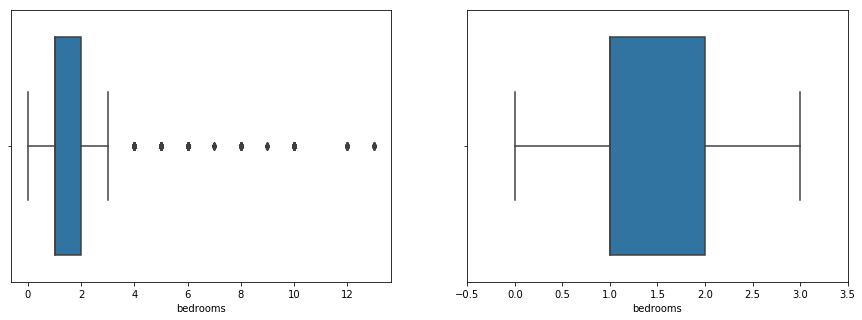

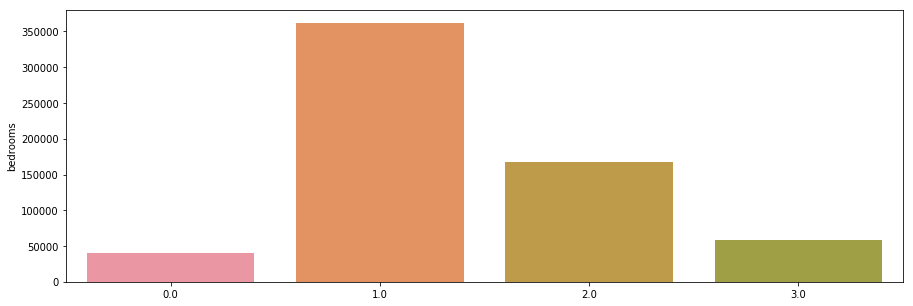

In [38]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [39]:
# opção: remover outliers
base_airbnb, qtd_linhas=excluir_outliers(base_airbnb, 'bedrooms')
print(f'{qtd_linhas} linhas removidas')

5482 linhas removidas


#### Variáveis discretas -> beds

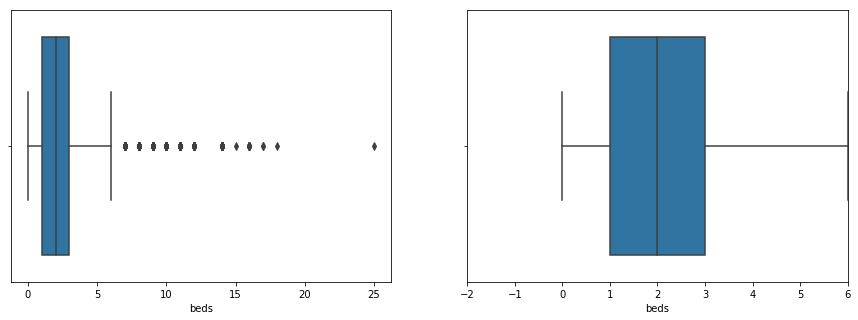

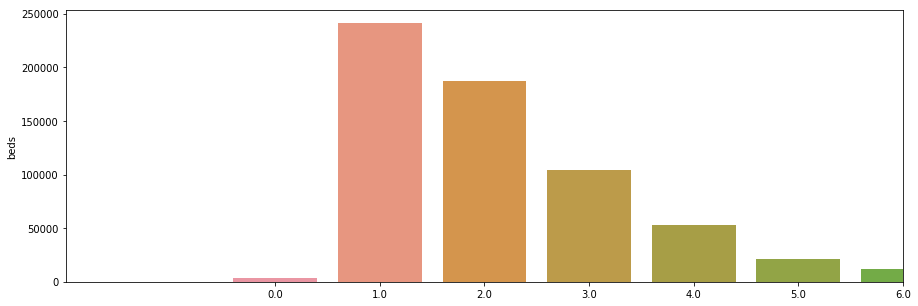

In [40]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [41]:
# opção: remover outliers
base_airbnb, qtd_linhas=excluir_outliers(base_airbnb, 'beds')
print(f'{qtd_linhas} linhas removidas')

5622 linhas removidas


#### Variáveis discretas -> guests_included

(1.0, 1.0)


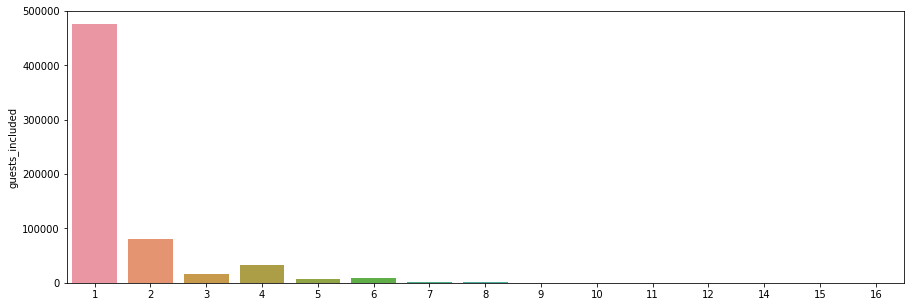

In [42]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])

print(limites(base_airbnb['guests_included']))
#vou querer um gráfico com todos os valores
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index,y=base_airbnb['guests_included'].value_counts())

Opção: Vamos remorer esta feature da análise. parece que os usuários do airbnb usam muito o valor padrão do aibnb como 1 guest inlcuded. É melhor excluir do modelo porque não vai ser um fator determinante para justificar as diferenças de preço.

In [43]:
base_airbnb=base_airbnb.drop('guests_included',axis=1)
base_airbnb.shape
base_airbnb.columns

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'extra_people',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'ano', 'mes'],
      dtype='object')

In [44]:
base_airbnb.shape

(622366, 22)

#### Variáveis discretas -> minimum_nights

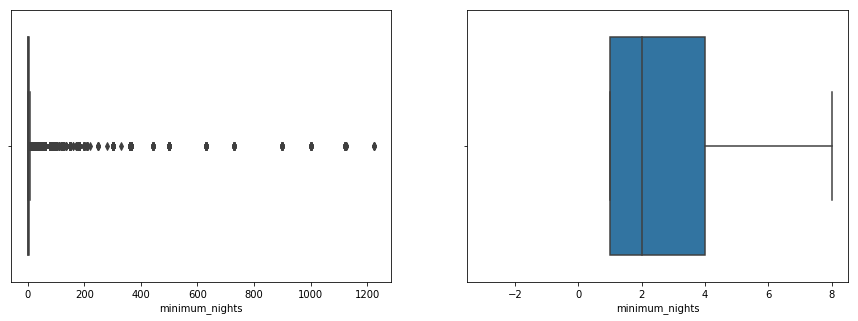

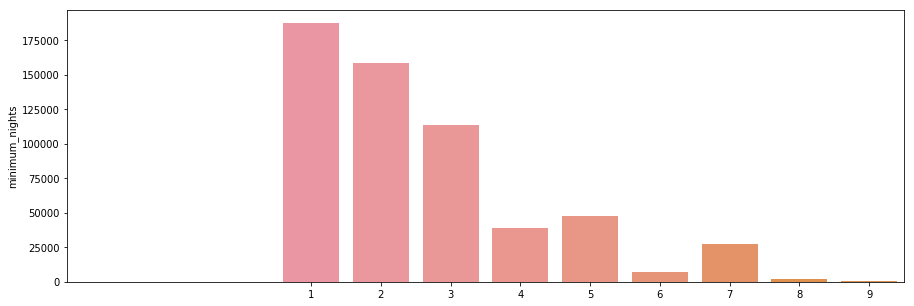

In [45]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [46]:
# opção: remover outliers
base_airbnb, qtd_linhas=excluir_outliers(base_airbnb, 'minimum_nights')
print(f'{qtd_linhas} linhas removidas')

40383 linhas removidas


#### Variáveis discretas -> maximum_nights 

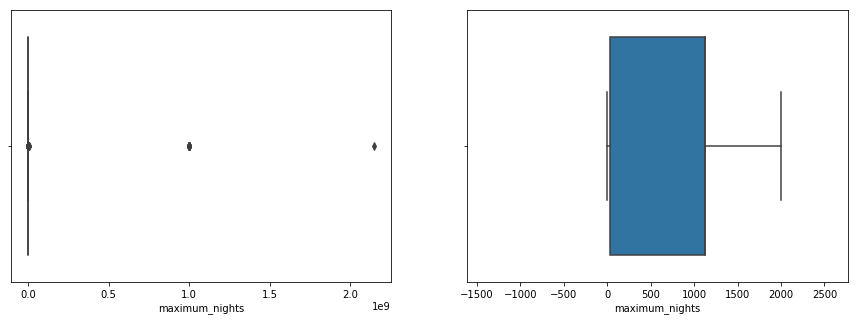

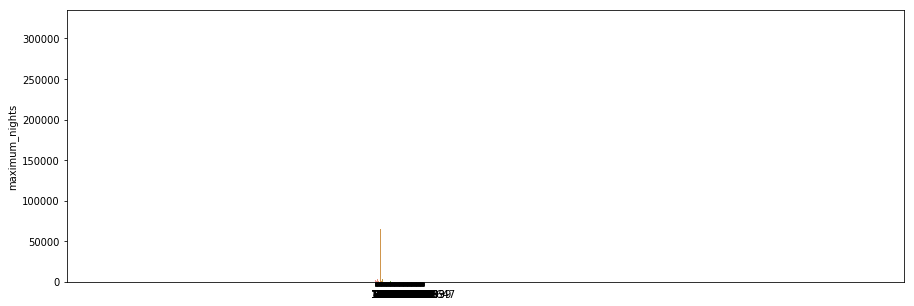

In [47]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [48]:
#opção: remover esta variável
base_airbnb=base_airbnb.drop('maximum_nights',axis=1)
base_airbnb.shape
base_airbnb.columns

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'extra_people',
       'minimum_nights', 'number_of_reviews', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes'],
      dtype='object')

#### Variáveis discretas -> number_of_reviews

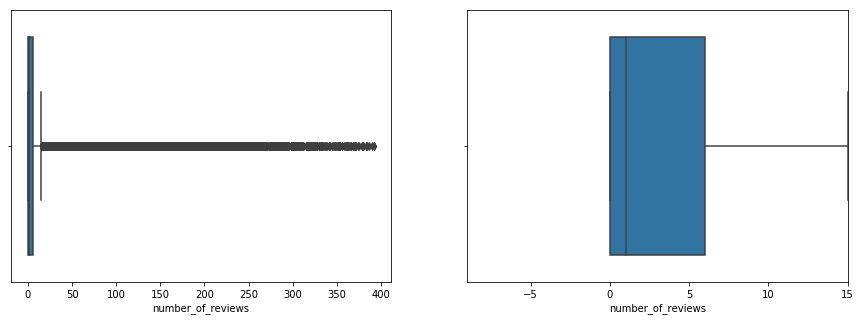

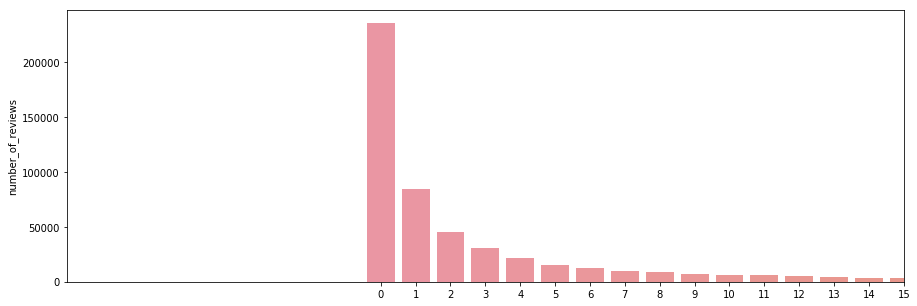

In [49]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [50]:
#opção: remover esta variável
base_airbnb=base_airbnb.drop('number_of_reviews',axis=1)
base_airbnb.shape

(581983, 20)

In [51]:
base_airbnb.columns

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready',
       'cancellation_policy', 'ano', 'mes'],
      dtype='object')

#### Variáveis de texto -> property_type

1) property_type
2) room_type
3) bed_type
4) cancellation_policy
5) amenities

In [52]:
print(base_airbnb['property_type'].value_counts())

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

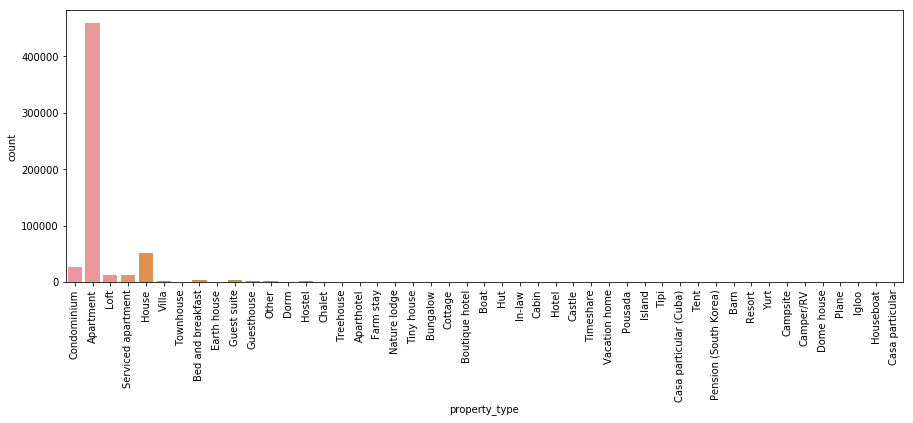

In [53]:
#ver em gráfico
plt.figure(figsize=(15,5))
grafico=sns.countplot('property_type',data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [54]:
# decisão: Vou agrupar todas as categorias abixo do other (<2000) em apenas uma só categoria

In [55]:
#lista das colunas que vou agrupar
tabelas_tipos_casa=base_airbnb['property_type'].value_counts()
colunas_agrupar=[]
for tipo in tabelas_tipos_casa.index:
    if tabelas_tipos_casa[tipo]<2000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']


In [56]:
# vou percorrer a lista de categorais e onde encontrar no dataframe vou substituir por outros
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo,'property_type']='Outros'

print(base_airbnb['property_type'].value_counts())

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


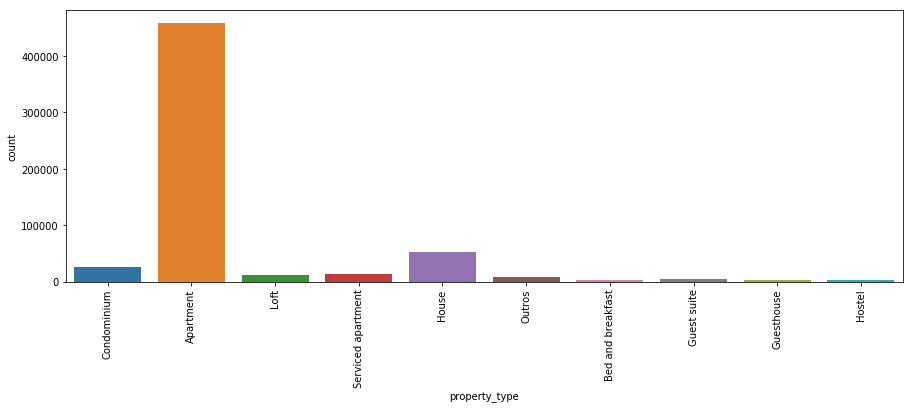

In [57]:
#ver em gráfico 2
plt.figure(figsize=(15,5))
grafico=sns.countplot('property_type',data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#### variáveis de texto -> room_type

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


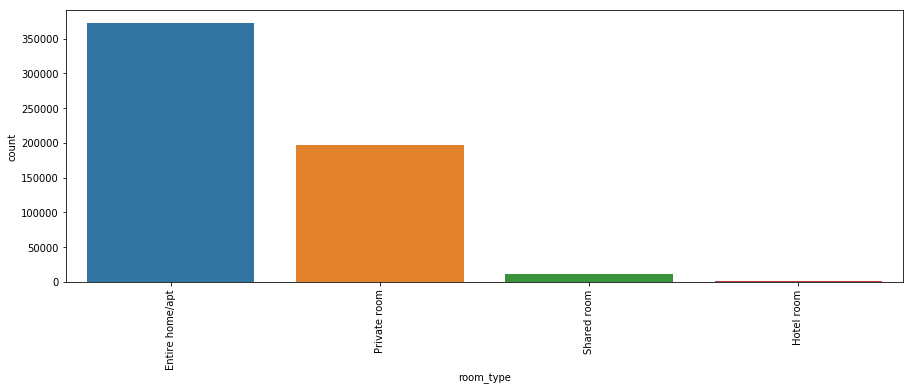

In [58]:
print(base_airbnb['room_type'].value_counts())
#ver em gráfico
plt.figure(figsize=(15,5))
grafico=sns.countplot('room_type',data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [59]:
#opção: não fazer nada

#### variáveis de texto -> bed_type

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


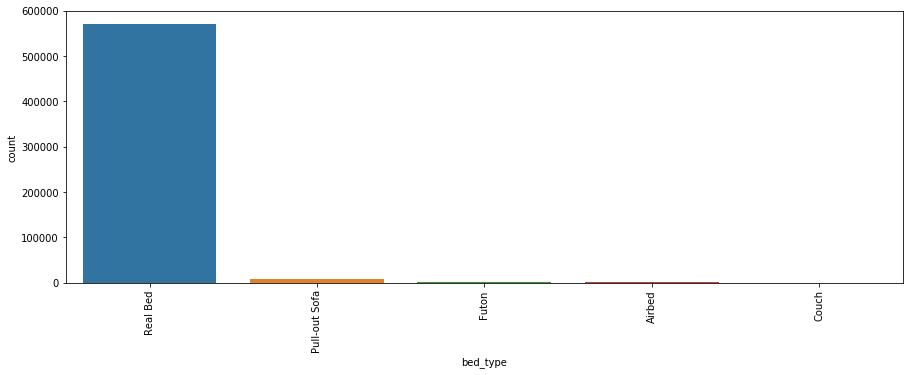

In [60]:
print(base_airbnb['bed_type'].value_counts())
#ver em gráfico
plt.figure(figsize=(15,5))
grafico=sns.countplot('bed_type',data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [61]:
#decisão grupar valores
tabela_bed_type=base_airbnb['bed_type'].value_counts()
colunas_agrupar=[]
for tipo in tabela_bed_type.index:
    if tipo != 'Real Bed':
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']


In [62]:
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo,'bed_type']='Outros'
    
print(base_airbnb['bed_type'].value_counts())

Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64


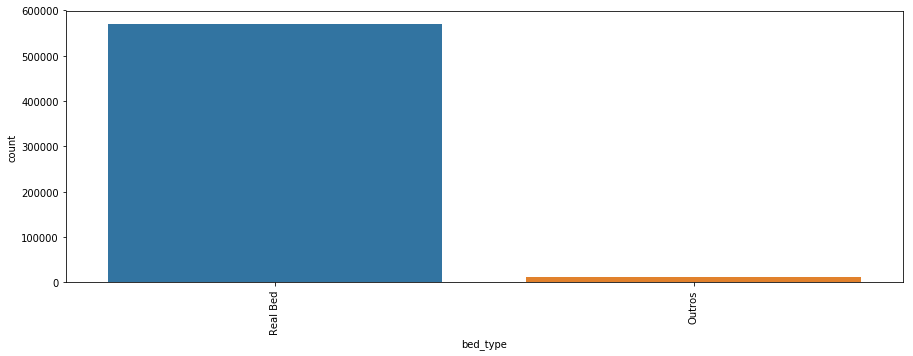

In [63]:
#ver em gráfico
plt.figure(figsize=(15,5))
grafico=sns.countplot('bed_type',data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#### variáveis de texto -> cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


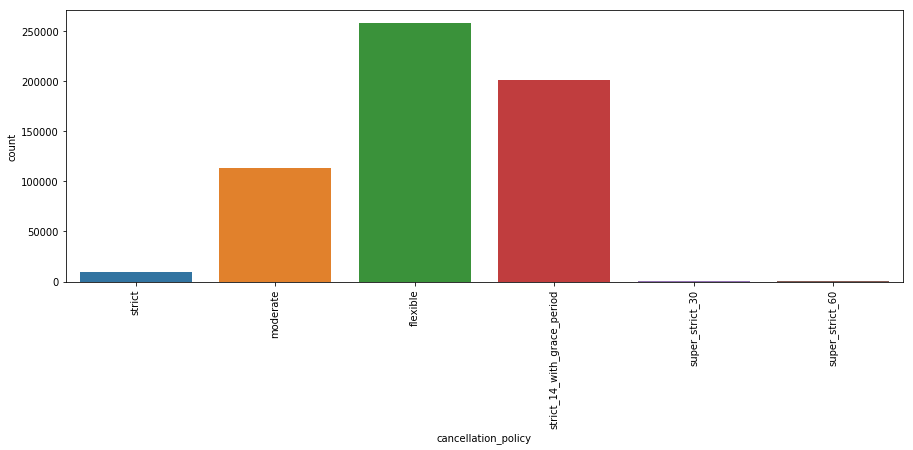

In [64]:
print(base_airbnb['cancellation_policy'].value_counts())
#ver em gráfico
plt.figure(figsize=(15,5))
grafico=sns.countplot('cancellation_policy',data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [65]:
#decisão: agrupar as categorias 
#lista das colunas que vou agrupar
tablea_cancellation=base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar=[]
for tipo in tablea_cancellation.index:
    if tablea_cancellation[tipo]<10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

['strict', 'super_strict_60', 'super_strict_30']


In [66]:
# vou percorrer a lista de categorais e onde encontrar no dataframe vou substituir por outros
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo,'cancellation_policy']='Outros'

print(base_airbnb['cancellation_policy'].value_counts())

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
Outros                           9863
Name: cancellation_policy, dtype: int64


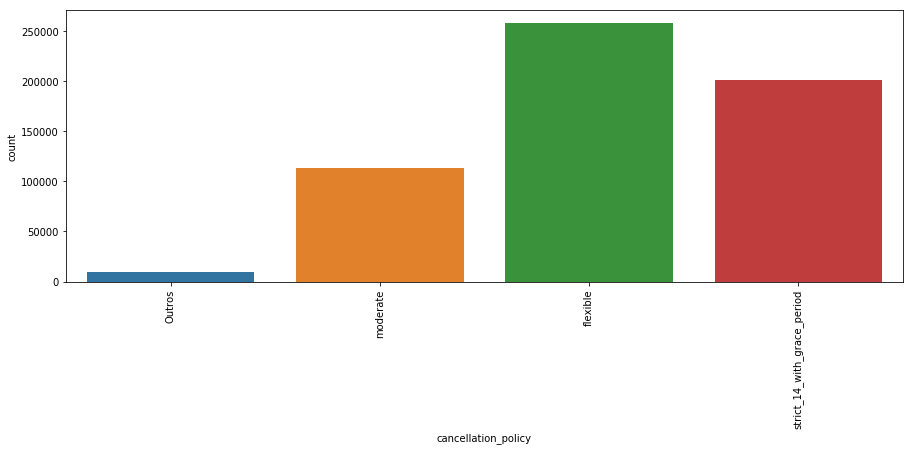

In [67]:
#ver em gráfico 2
plt.figure(figsize=(15,5))
grafico=sns.countplot('cancellation_policy',data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#### variáveis de texto -> amenities -> lista de valores

In [68]:
#primeiro registo
base_airbnb['amenities'].iloc[0]

'{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Paid parking off premises","Smoking allowed",Doorman,Elevator,"Hot tub","Family/kid friendly","Suitable for events",Essentials,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in","Front desk/doorperson","Private entrance","Hot water","Bed linens","Luggage dropoff allowed"}'

In [69]:
#segundo registo
base_airbnb['amenities'].iloc[1]

'{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Doorman,Elevator,"Buzzer/wireless intercom","Family/kid friendly",Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}'

Em vez de avaliar os itens vou contar o número de itens-> relação esperada: quanto mais amenites mais caro será o imóvel. Se o host colocou muitas comodidades é porque efetivamente tem mais ou o host é mais atencioso e criterioso, pelo que espero que tenha impacto no preço do imóvel. 

In [70]:
#lista de todos os amenites
print(base_airbnb['amenities'].iloc[0].split(','))
print(len(base_airbnb['amenities'].iloc[0].split(','))) # conto o número de amenites

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
25


In [71]:
# coloco .str porque é uma função de string e tenho que utilizar o apply para aplicar o len a cada linha
base_airbnb['n_amenities']=base_airbnb['amenities'].str.split(',').apply(len)

In [72]:
base_airbnb=base_airbnb.drop('amenities',axis=1)

In [73]:
base_airbnb.shape

(581983, 20)

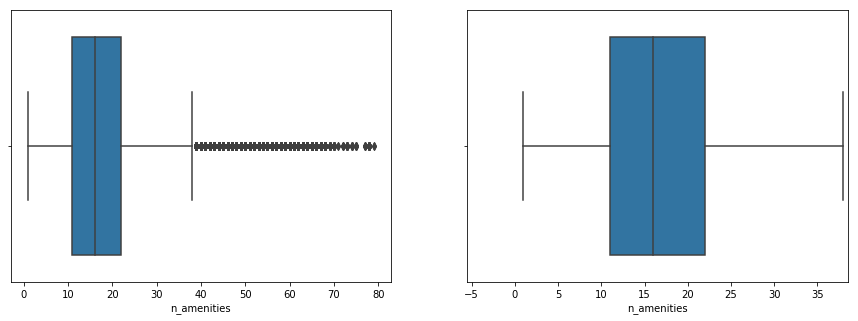

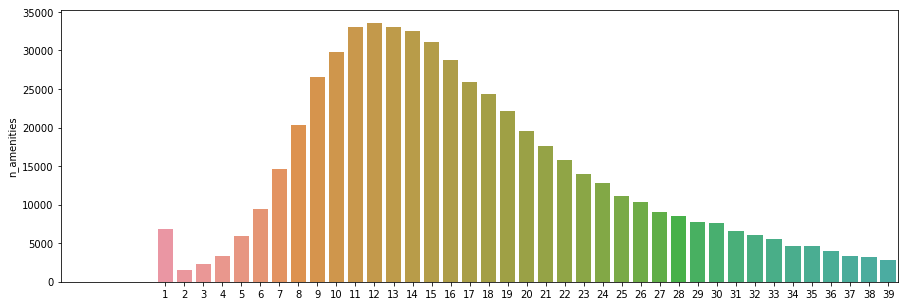

In [74]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [75]:
# opção: remover outliers
base_airbnb, qtd_linhas=excluir_outliers(base_airbnb, 'n_amenities')
print(f'{qtd_linhas} linhas removidas')

24343 linhas removidas


#### visulaização de mapa das propriedades

In [76]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

## Encoding

In [77]:
print(base_airbnb.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'extra_people', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'ano', 'mes', 'n_amenities'],
      dtype='object')


### Tratar os Verdadeiros ou Falsos

In [78]:
colunas_tf=['host_is_superhost','instant_bookable','is_business_travel_ready']

In [79]:
base_airbnb.iloc[0]

host_is_superhost                         t
host_listings_count                     2.0
latitude                         -22.965919
longitude                        -43.178962
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                               1.0
bedrooms                                2.0
beds                                    2.0
bed_type                           Real Bed
price                                 270.0
extra_people                           51.0
minimum_nights                            4
instant_bookable                          t
is_business_travel_ready                  f
cancellation_policy                  Outros
ano                                    2018
mes                                       4
n_amenities                              25
Name: 1, dtype: object

In [80]:
base_airbnb_cod=base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t',coluna]=1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f',coluna]=0
base_airbnb_cod.iloc[0]

host_is_superhost                         1
host_listings_count                     2.0
latitude                         -22.965919
longitude                        -43.178962
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                               1.0
bedrooms                                2.0
beds                                    2.0
bed_type                           Real Bed
price                                 270.0
extra_people                           51.0
minimum_nights                            4
instant_bookable                          1
is_business_travel_ready                  0
cancellation_policy                  Outros
ano                                    2018
mes                                       4
n_amenities                              25
Name: 1, dtype: object

### Tratar Categorias

In [81]:
colunas_categorias=['property_type','room_type','bed_type','cancellation_policy']

In [82]:
base_airbnb_cod=pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   
5                      0                0                  1   
6                      0                0                  1   

   cancellation_policy_Outros  cancellation_policy_flexible  \
1                           1                             0   
3                           1                             0   
4                           1                             0   
5                           1                             0   
6                           1                             0   

   cancellation_policy_moderate  \
1                             0   
3                             0   
4                             0   
5                             0   
6                             0   

   cancellation_policy_strict_14_with_grace_period  
1                                                0  
3                                                0  
4                                                0  
5                                                0  
6                                                0  

[5 rows x 36 columns]

## Modelos

### Modelo de Previsão 

In [83]:
#construir função de avaliação -> utilizo o R2 e o RSME (Erro quadrático médio)
def avaliar_modelo(nome_modelo, y_teste, y_previsto):
    r2=r2_score(y_teste,y_previsto)
    RSME=np.sqrt(mean_squared_error(y_teste,y_previsto))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Modelos utilizados:
    1. RandomForest
    2. LinearRegression
    3. Extra Tree

In [84]:
#modelos que vou utilizar

modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

#base de dados que utilizo -> separar as variráveis entre a variável principal e as restantes
y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1) #todas as variáveis menos a que quero prever

### Separar os dados entre treino  e teste

In [85]:
#randon_test -> para obter sempre a mesma divisão nos dados sempre que rodar o código -> default train:75% teste:25%
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

### Calcular os modelos

In [86]:
for nome_modelo, modelo in modelos.items(): #obter a chave e o conteúdo das variáveis do dicionário
    #treinar modelo
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))
    print('-'*30)

Modelo RandomForest:
R²:96.79%
RSME:47.50
------------------------------
Modelo LinearRegression:
R²:32.70%
RSME:217.54
------------------------------
Modelo ExtraTrees:
R²:97.19%
RSME:44.45
------------------------------


O modelo escolhido como melhor é o ExtraTrees porque o modelo tem o maior valor de R2 e ao mesmo tempo menor RSME. Como não tivemos uma grande diferença entre este modelo e o RandomForest a opção vai para o ExtraTrees também porque o tempo de execução é menor. O modelo LinearRegression obteve os piores resultados.

### Ajustes e Melhorias ao Melhor Modelo

In [87]:
#lista do contributo das variáveis -> mesma ordem do X (de teste ou treino)
print(modelo_et.feature_importances_)

[0.01343941 0.03961436 0.10270349 0.10205435 0.06704181 0.08187549
 0.10168624 0.05226826 0.08780244 0.0654284  0.02226619 0.
 0.01109204 0.00474755 0.09006972 0.0128029  0.00120402 0.00543254
 0.00062683 0.0009311  0.00057149 0.00737722 0.00237066 0.00237527
 0.00220785 0.07040005 0.00036243 0.00320183 0.00192381 0.00250806
 0.00253732 0.00088299 0.01945662 0.01258693 0.00815035]


In [88]:
print(X_train.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready', 'ano',
       'mes', 'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'bed_type_Outros',
       'bed_type_Real Bed', 'cancellation_policy_Outros',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')


In [89]:
#juntar as 2 listas -> num dataframe
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
display(importancia_features)

0
host_is_superhost                                0.013439
host_listings_count                              0.039614
latitude                                         0.102703
longitude                                        0.102054
accommodates                                     0.067042
bathrooms                                        0.081875
bedrooms                                         0.101686
beds                                             0.052268
extra_people                                     0.087802
minimum_nights                                   0.065428
instant_bookable                                 0.022266
is_business_travel_ready                         0.000000
ano                                              0.011092
mes                                              0.004748
n_amenities                                      0.090070
property_type_Apartment                          0.012803
property_type_Bed and breakfast                  0.001204
property_type_Condominium                        0.005433
property_type_Guest suite                        0.000627
property_type_Guesthouse                         0.000931
property_type_Hostel                             0.000571
property_type_House                              0.007377
property_type_Loft                               0.002371
property_type_Outros                             0.002375
property_type_Serviced apartment                 0.002208
room_type_Entire home/apt                        0.070400
room_type_Hotel room                             0.000362
room_type_Private room                           0.003202
room_type_Shared room                            0.001924
bed_type_Outros                                  0.002508
bed_type_Real Bed                                0.002537
cancellation_policy_Outros                       0.000883
cancellation_policy_flexible                     0.019457
cancellation_policy_moderate                     0.012587
cancellation_policy_strict_14_with_grace_period  0.008150

In [90]:
#ordenar a dataframe
importancia_features=importancia_features.sort_values(by=0,ascending=False)
display(importancia_features)

0
latitude                                         0.102703
longitude                                        0.102054
bedrooms                                         0.101686
n_amenities                                      0.090070
extra_people                                     0.087802
bathrooms                                        0.081875
room_type_Entire home/apt                        0.070400
accommodates                                     0.067042
minimum_nights                                   0.065428
beds                                             0.052268
host_listings_count                              0.039614
instant_bookable                                 0.022266
cancellation_policy_flexible                     0.019457
host_is_superhost                                0.013439
property_type_Apartment                          0.012803
cancellation_policy_moderate                     0.012587
ano                                              0.011092
cancellation_policy_strict_14_with_grace_period  0.008150
property_type_House                              0.007377
property_type_Condominium                        0.005433
mes                                              0.004748
room_type_Private room                           0.003202
bed_type_Real Bed                                0.002537
bed_type_Outros                                  0.002508
property_type_Outros                             0.002375
property_type_Loft                               0.002371
property_type_Serviced apartment                 0.002208
room_type_Shared room                            0.001924
property_type_Bed and breakfast                  0.001204
property_type_Guesthouse                         0.000931
cancellation_policy_Outros                       0.000883
property_type_Guest suite                        0.000627
property_type_Hostel                             0.000571
room_type_Hotel room                             0.000362
is_business_travel_ready                         0.000000

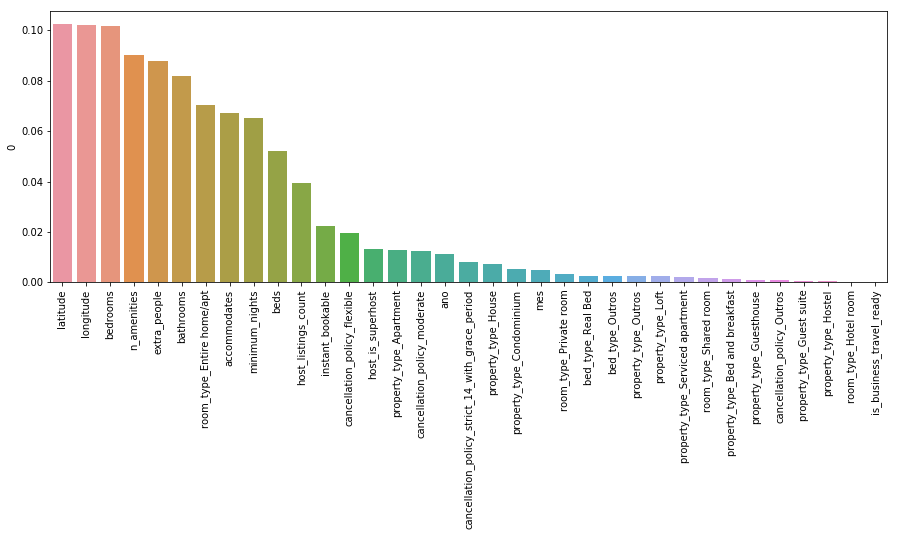

In [91]:
# colocar os valores num gráfico
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features.loc[:,0])
ax.tick_params(axis='x', rotation=90)

#### Eliminar Variáveis

In [92]:
#base de dados que utilizo -> separar as variráveis entre a variável principal e as restantes
#eliminar a variável -> 'is_business_travel_ready' (menor contibuto)
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1) #todas as variáveis menos a que quero prever

#randon_test -> para obter sempre a mesma divisão nos dados sempre que rodar o código -> default train:75% teste:25%
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


modelo_et.fit(X_train, y_train)
#testar
previsao = modelo_et .predict(X_test)
print(avaliar_modelo(nome_modelo, y_test, previsao))


Modelo ExtraTrees:
R²:97.18%
RSME:44.54


In [93]:
#base de dados que utilizo -> separar as variráveis entre a variável principal e as restantes
#eliminar a variável -> 'is_business_travel_ready' (menor contibuto)
base_teste=base_airbnb_cod.copy()

for coluna in base_teste:
    if 'bed_type' in coluna:    
        base_teste = base_teste.drop(coluna, axis=1)

y = base_teste['price']
X = base_teste.drop('price', axis=1) #todas as variáveis menos a que quero prever

#randon_test -> para obter sempre a mesma divisão nos dados sempre que rodar o código -> default train:75% teste:25%
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


modelo_et.fit(X_train, y_train)
#testar
previsao = modelo_et .predict(X_test)
print(avaliar_modelo(nome_modelo, y_test, previsao))


Modelo ExtraTrees:
R²:97.20%
RSME:44.36


## Deploy - tormar modelo acessível (Strealit)

Consiste em gravar o modelo num arquivo para que possa ser utilizado.

In [94]:
# Salvar a base de dados já tratada das caracteristicas e salavar como csv
X['price'] = y
X.to_csv('dados.csv')

In [96]:
import joblib
joblib.dump(modelo_et, 'modelo.joblib') # colocar .joblib para saber que devo utilizar o joblib

['modelo.joblib']